In [ ]:
!pip install importlib-metadata

In [ ]:
from cvrp import CVRP
from state import State
from action import Action
from utils import transition, cost

In [ ]:
cities = [[0, 0], [1, 2], [3, 5], [6, 8]]  # Depot at [0,0], and three cities
demands = [0, 2, 3, 1]  # Depot demand is 0, other cities have demand
capacity = 5

In [ ]:
cvrp_instance = CVRP(cities=cities, demands=demands, capacity=capacity)
initial_state = State(cvrp_instance)

In [ ]:
cvrp_instance.distance_matrix

In [ ]:
action_generator = Action(cvrp_instance, initial_state)

In [ ]:
feasible_actions = action_generator.get_all_actions()
print("\nFeasible Actions from Initial State:")
for route in feasible_actions:
    print(route)

In [ ]:
example_action = feasible_actions[0]  # Pick the first feasible action
new_state = transition(initial_state, example_action)

In [ ]:
if new_state:
    print("\nNew State (Visited Status):", new_state.visited)
    route_cost = cost(cvrp_instance, example_action)
    print(f"Cost of route {example_action}: {route_cost}")
else:
    print("The chosen action revisits cities and is therefore invalid.")

In [ ]:
new_action_generator = Action(cvrp_instance, new_state)
feasible_actions = new_action_generator.get_all_actions()
print("\nFeasible Actions from new State:")
for route in feasible_actions:
    print(route)

In [ ]:
example_action = feasible_actions[2]
new_state = transition(new_state, example_action)
if new_state:
    print("\nNew State (Visited Status):", new_state.visited)
    route_cost = cost(cvrp_instance, example_action)
    print(f"Cost of route {example_action}: {route_cost}")
else:
    print("The chosen action revisits cities and is therefore invalid.")

In [ ]:
from policy import policy_evaluation_with_milp

## Test 2

In [ ]:
cities = [(2, 3), (5, 8), (1, 9), (7, 3)]
demands = [0, 2, 3, 4, 5]
capacity = 10
cvrp_instance = CVRP(cities=[(0, 0)] + cities, demands=demands, capacity=capacity)


In [ ]:
initial_state = State(cvrp_instance)
print("Initial State (visited):", initial_state.visited)


In [ ]:
action_generator = Action(cvrp_instance, initial_state)
feasible_actions = action_generator.get_all_actions()
print("Feasible Actions:", feasible_actions)

In [ ]:
from policy import ValueNetwork
from utils import solve_milp_with_value_function

In [ ]:
value_network = ValueNetwork(input_size=len(initial_state.encode_state()), hidden_dim=16)
route = solve_milp_with_value_function(cvrp_instance, initial_state, value_network)
print("MILP Optimal Route:", route)

## Testing OR-tools


In [1]:
from cvrp import CVRP
from ORtools import ORToolsSolver
from parser import parse_cvrplib

In [2]:
file_path = "C:/Users/issam/OneDrive/Desktop/phd/Vrp-Set-A/A/A-n32-k5.vrp"
depot, cities, demands, capacity, num_vehicles = parse_cvrplib(file_path)

In [3]:
cvrp_instance = CVRP(cities=[cities[depot]] + cities, demands=[0] + demands, capacity=capacity, num_vehicles=num_vehicles ,depot_index=0)

In [4]:
ortools_solver = ORToolsSolver(cvrp_instance)
solution, total_cost = ortools_solver.solve()

Vehicle 0 route cost: 279.96843209460496
Vehicle 1 route cost: 64.49396438693266
Vehicle 2 route cost: 123.48833299747402
Vehicle 3 route cost: 209.15282568699925
Vehicle 4 route cost: 43.62752756694886


In [5]:
total_cost 

720.7310827329597

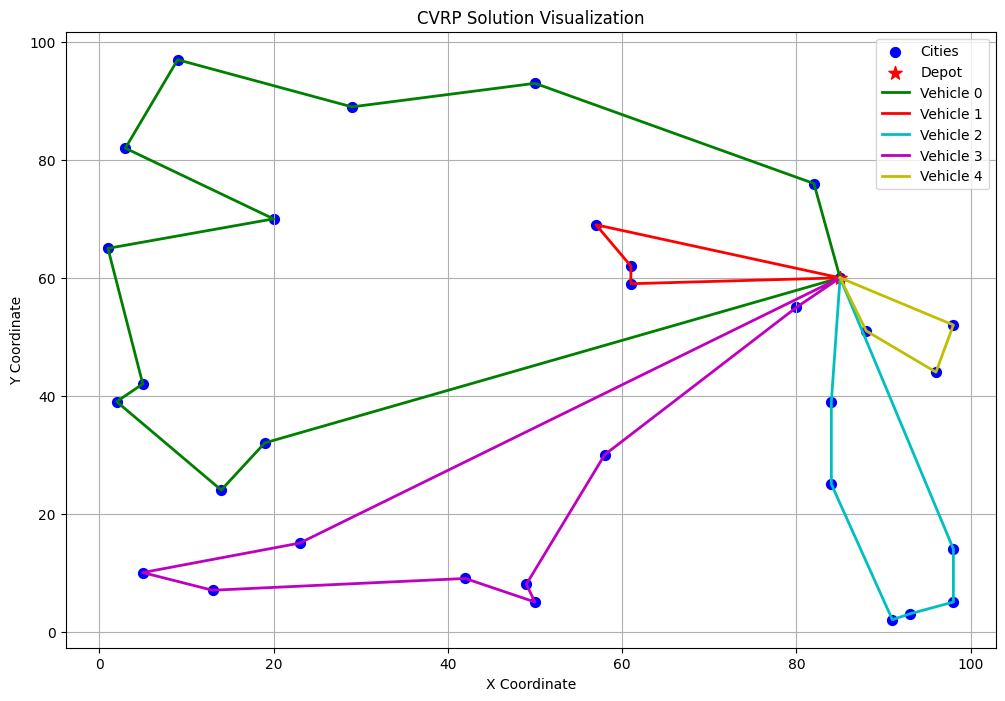

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract coordinates and routes
routes = ortools_solver.get_solution_routes(solution)

# Plot setup
plt.figure(figsize=(12, 8))

# Plot all cities
x_coords = [city[0] for city in cvrp_instance.cities]
y_coords = [city[1] for city in cvrp_instance.cities]
plt.scatter(x_coords, y_coords, c='blue', s=50, label='Cities')

# Plot depot
plt.scatter(x_coords[0], y_coords[0], c='red', s=100, marker='*', label='Depot')

# Plot routes with different colors for each vehicle
colors = ['g', 'r', 'c', 'm', 'y']
for vehicle_id, route in enumerate(routes):
    route_coords = [(x_coords[i], y_coords[i]) for i in route]
    route_x = [x for x, y in route_coords]
    route_y = [y for x, y in route_coords]
    plt.plot(route_x, route_y, c=colors[vehicle_id], linewidth=2, label=f'Vehicle {vehicle_id}')

plt.title('CVRP Solution Visualization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()
